# Imports

In [49]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from src.sam_segmentation.yolo import load_yolov8_detector, yolov8_detect, draw_bounding_boxes
from src.sam_segmentation.sam import load_sam_predictor, sam_segmentation
from src.sam_segmentation.utils import unite_masks

# Utils functions


In [50]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# YOLOv8 trained on custom bubbles dataset

In [51]:
custom_yolo_checkpoint_path = r"C:\Internship\ITMO_ML\CTCI\checkpoints\yolov8\yolov8s_on_bubbles_24\run3\weights\best.pt"
detector = load_yolov8_detector(custom_yolo_checkpoint_path)

In [52]:
print(type(detector))

<class 'ultralytics.models.yolo.model.YOLO'>


In [53]:
image = cv2.imread(r'C:\Internship\ITMO_ML\CTCI\data\frame-1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

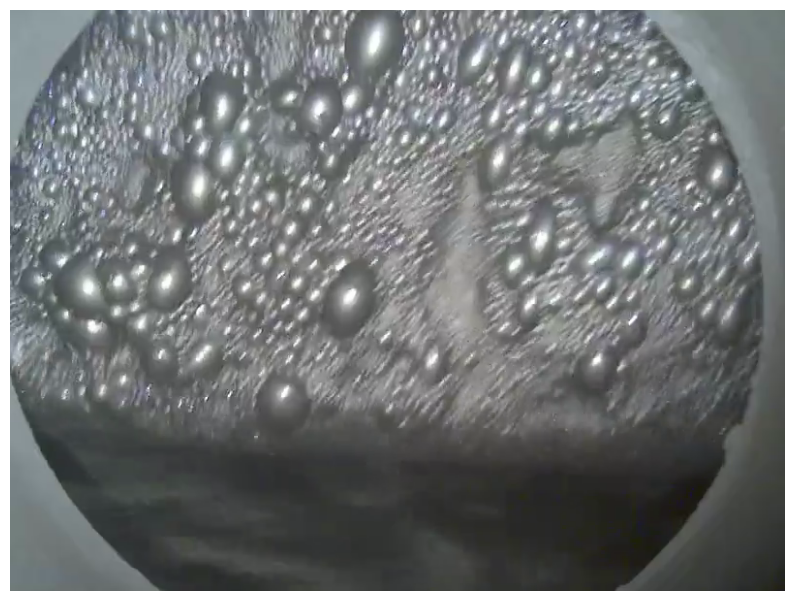

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [55]:
boxes = yolov8_detect(image=image, detector=detector, return_objects=False)

0: 608x800 300 Bubbless, 71.3ms
Speed: 5.0ms preprocess, 71.3ms inference, 3.0ms postprocess per image at shape (1, 3, 608, 800)


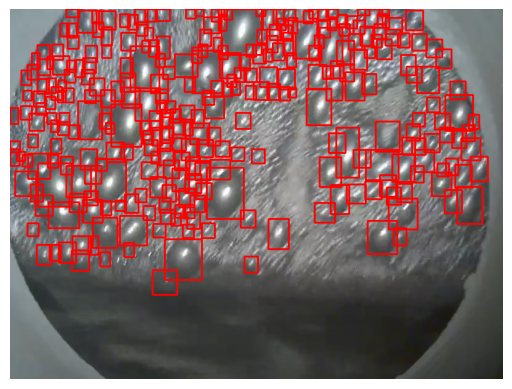

In [56]:
image_example = image.copy()

draw_bounding_boxes(image=image_example, boxes=boxes)

# SAM Checkpoint

In [57]:
sam_checkpoint = r"C:\Internship\ITMO_ML\CTCI\checkpoints\sam_checkpoints\sam_vit_h_4b8939.pth"
model_type = "vit_h"
device="cuda"

predictor = load_sam_predictor(checkpoint_path=sam_checkpoint, model_type=model_type, device=device)

# Segmentation by bounding box prompt

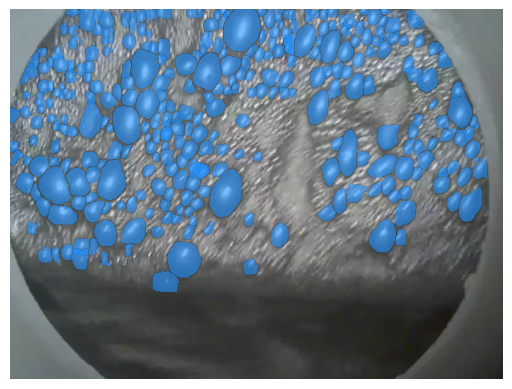

In [58]:
masks_list = sam_segmentation(image=image, predictor=predictor, boxes=boxes, prompt_point=False)
plt.figure()
plt.imshow(image)

for i in range(len(masks_list)):
    masks = masks_list[i]
    show_mask(masks[0], plt.gca())

plt.axis('off')
plt.show()

Объединение масок:

In [59]:
masks_united = []
for masks in masks_list:
    masks_united.append(unite_masks(masks))


In [60]:
mask_united = unite_masks(masks_united)

"Урезание" масок:

In [82]:
narrowing = 0.25

In [83]:
masks_narrowed = []
for mask in masks_united:
    _, thresh = cv2.threshold(mask, 127, 255, 0)
    dist_expanded = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, mask_narrowed = cv2.threshold(dist_expanded, narrowing * dist_expanded.max(), 255, cv2.THRESH_BINARY)
    masks_narrowed.append(mask_narrowed)

In [84]:
mask_united_narrowed = unite_masks(masks_narrowed)

Результат:

Text(0.5, 1.0, 'Maks narrowed, narrowing=0.25')

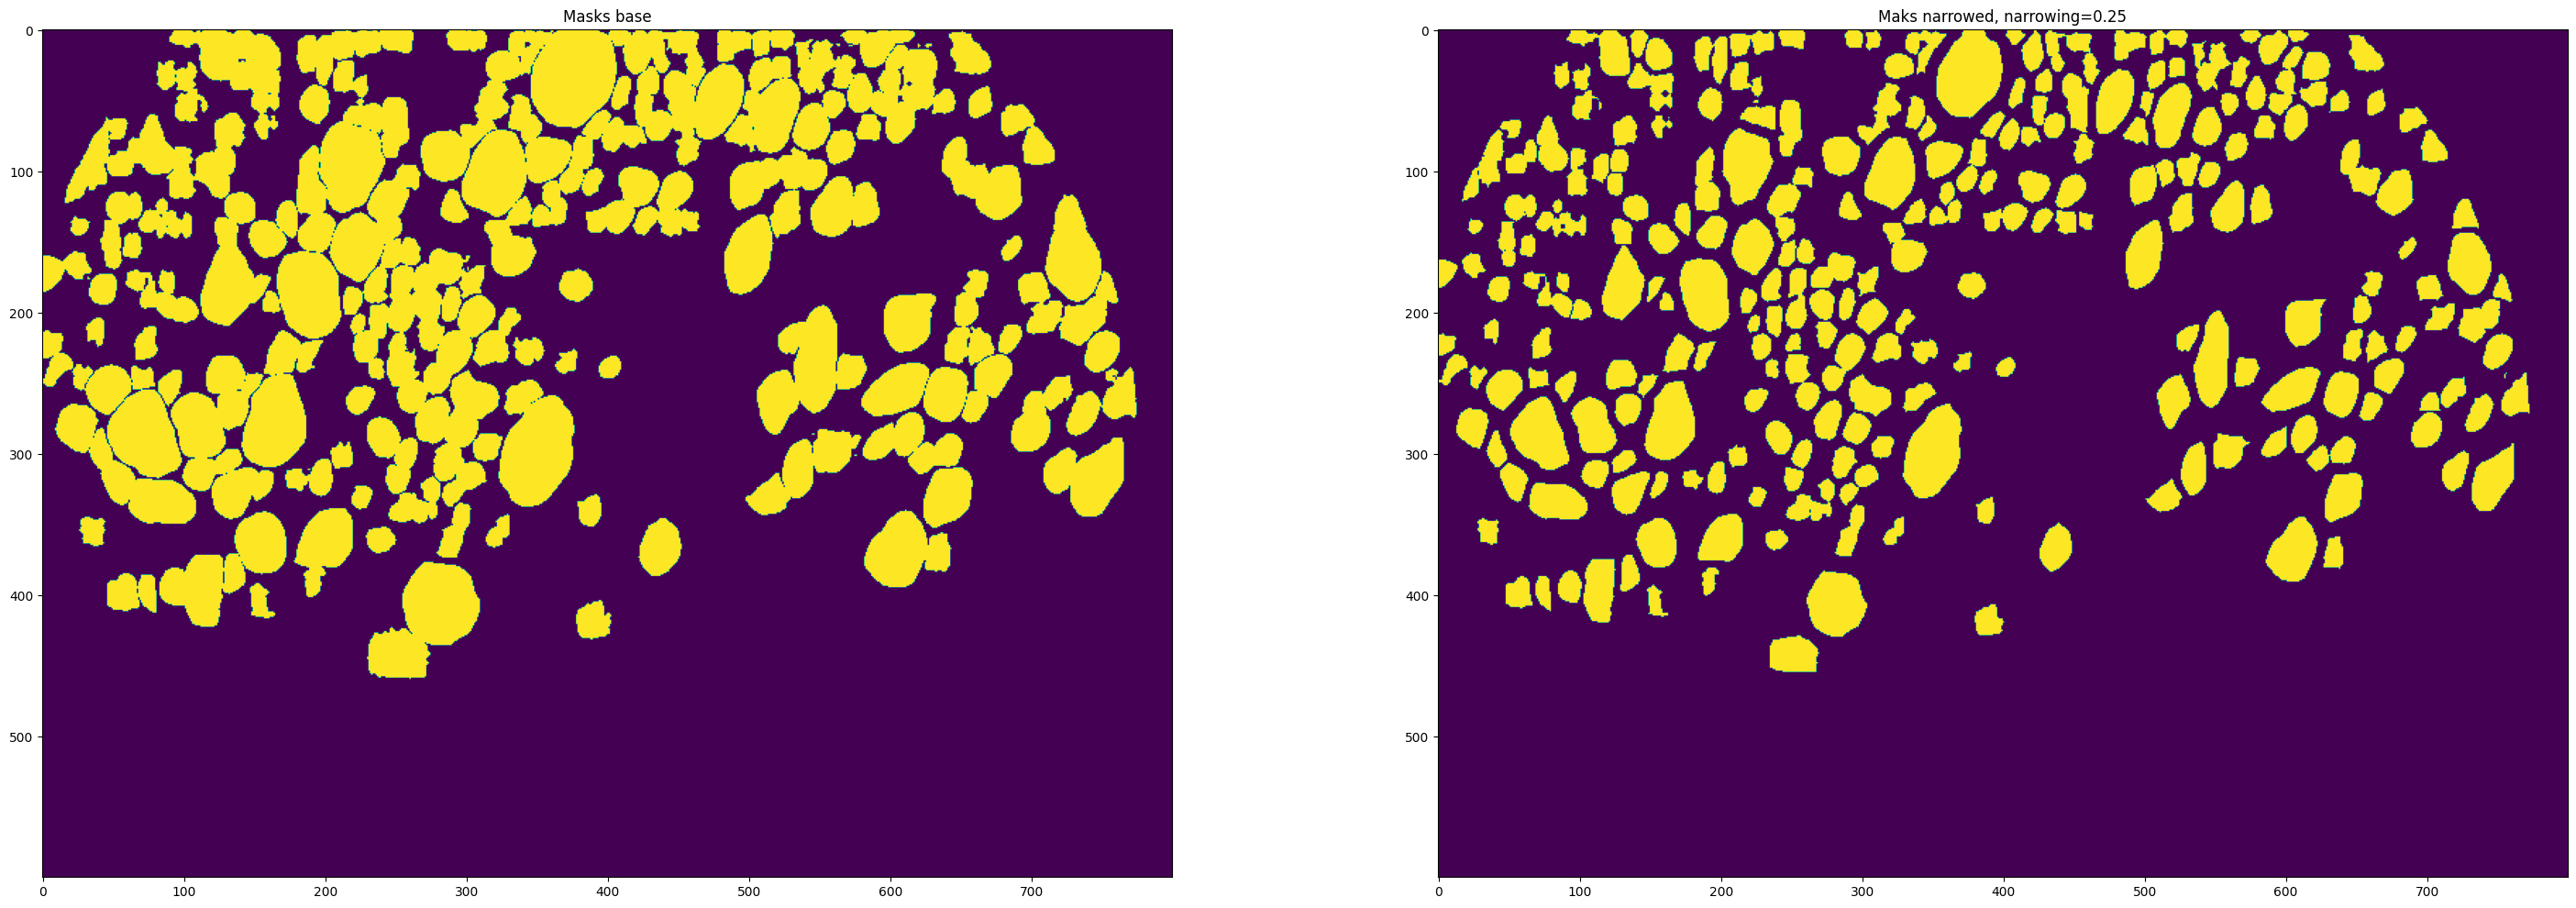

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(36, 12)

ax[0].imshow(mask_united)
ax[0].set_title("Masks base")
ax[1].imshow(mask_united_narrowed)
ax[1].set_title(f"Maks narrowed, narrowing={narrowing}")

# Segmentation by bounding box and point prompt


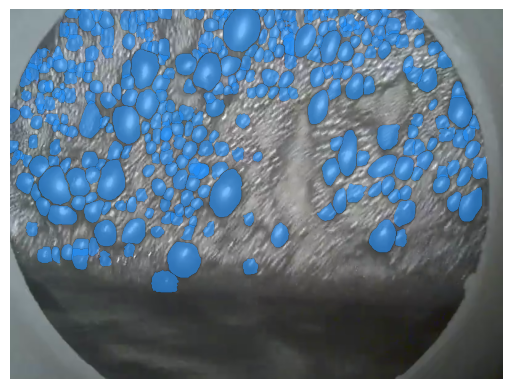

In [69]:
masks_list = sam_segmentation(image=image, predictor=predictor, boxes=boxes, prompt_point=True)

plt.figure()
plt.imshow(image)

for i in range(len(masks_list)):
    masks = masks_list[i]
    show_mask(masks[0], plt.gca())

plt.axis('off')
plt.show()